In [1]:
import warnings
warnings.filterwarnings('ignore')
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt


In [3]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


In [2]:
from pmdarima import auto_arima

In [3]:
from sklearn.metrics import mean_squared_error

In [4]:
from statsmodels.tsa.arima.model import ARIMA

In [7]:
#from statsmodels.tsa.arima.model import SARIMAXResults

ImportError: cannot import name 'SARIMAXResults' from 'statsmodels.tsa.arima.model' (/Users/Daniyar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/arima/model.py)

In [5]:
df = pd.read_csv('/Users/Daniyar/Mountains/Data/df_final.csv', index_col="time")

In [6]:
# Define features and target
X = df.drop(columns=['generation solar','generation wind onshore'])
y_solar = df['generation solar']
y_wind = df['generation wind onshore']

In [7]:
y_solar

time
2014-12-31 23:00:00+00:00    49.0
2015-01-01 00:00:00+00:00    50.0
2015-01-01 01:00:00+00:00    50.0
2015-01-01 02:00:00+00:00    50.0
2015-01-01 03:00:00+00:00    42.0
                             ... 
2018-12-31 18:00:00+00:00    85.0
2018-12-31 19:00:00+00:00    33.0
2018-12-31 20:00:00+00:00    31.0
2018-12-31 21:00:00+00:00    31.0
2018-12-31 22:00:00+00:00    31.0
Name: generation solar, Length: 35064, dtype: float64

In [8]:
def split_by_date(X,train_end_date):
    if not isinstance(train_end_date, pd.Timestamp):
        train_end_date = pd.Timestamp(train_end_date)

    # Convert index of X and y to Timestamp objects if they are strings
    if isinstance(X.index[0], str):
        X.index = pd.to_datetime(X.index)
        
    X_train = X[X.index <= train_end_date]
    X_test = X[X.index > train_end_date]
    
    return X_train, X_test

train_end_date = pd.to_datetime('2017-12-31 23:00:00+00:00')
X_train, X_test = split_by_date(X,train_end_date)

In [9]:
y_solar_train, y_solar_test = split_by_date(y_solar, train_end_date)

In [10]:
y_wind_train, y_wind_test = split_by_date(y_wind, train_end_date)

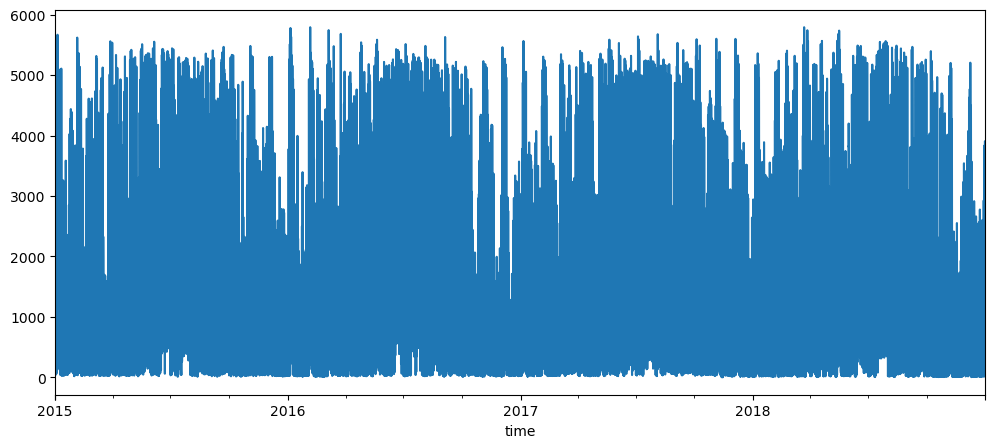

In [11]:
y_solar.plot(figsize=(12, 5))
plt.show()

In [14]:
from statsmodels.tsa.stattools import adfuller
def adf_test(dataset):
     dftest = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",dftest[0])
     print("2. P-Value : ", dftest[1])
     print("3. Num Of Lags : ", dftest[2])
     print("4. Num Of Observations Used For ADF Regression:",      dftest[3])
     print("5. Critical Values :")
     for key, val in dftest[4].items():
         print("\t",key, ": ", val)
adf_test(y_solar)

1. ADF :  -13.889170343077325
2. P-Value :  6.011902403279588e-26
3. Num Of Lags :  52
4. Num Of Observations Used For ADF Regression: 35011
5. Critical Values :
	 1% :  -3.43053679213716
	 5% :  -2.8616225575095284
	 10% :  -2.566813942767471


In [15]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

# Assuming y_solar_train is already loaded and a pd.Series
test_stationarity(y_solar_train)

Results of Dickey-Fuller Test:
Test Statistic                -1.221940e+01
p-value                        1.116233e-22
#Lags Used                     4.900000e+01
Number of Observations Used    2.625500e+04
Critical Value (1%)           -3.430599e+00
Critical Value (5%)           -2.861650e+00
Critical Value (10%)          -2.566829e+00
dtype: float64


/Users/Daniyar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


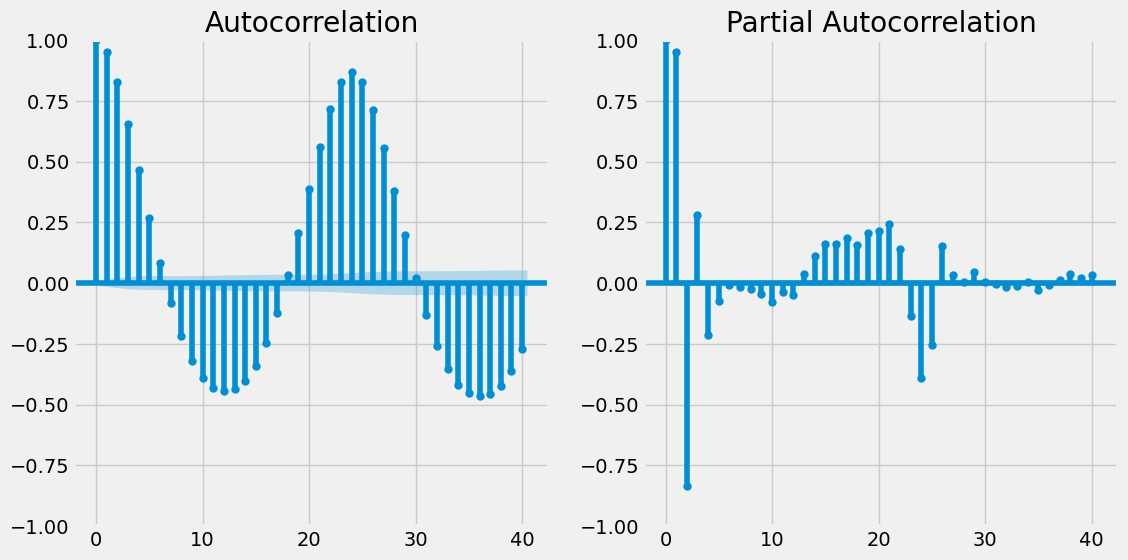

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(y_solar_train, ax=plt.gca(), lags=40)
plt.subplot(122)
plot_pacf(y_solar_train, ax=plt.gca(), lags=40)
plt.show()

In [ ]:
stepwise_fit = auto_arima(y_solar_train, trace=True,
                                            suppress_warnings = True) 

stepwise_fit.summary()
    

In [ ]:
model_arima = ARIMA(y_solar_train, order=(4,1,4))
model_arima_fit = model_arima.fit()
model_arima_fit.summary()

In [12]:
mod = ARIMA(y_solar_train, order=(1, 0, 2), seasonal_order=(1, 1, 1, 365))
res = mod.fit(method='innovations_mle', low_memory=True, cov_type='none')
res.summary()

/Users/Daniyar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/Daniyar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/Daniyar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


KeyboardInterrupt: 

In [ ]:
residuals = pd.DataFrame(model_arima_fit.resid)

plt.figure(figsize=(12,6))
plt.subplot(211)
residuals.plot(title="Residuals", ax=plt.gca())
plt.subplot(212)
residuals.plot(kind='kde', title='Density', ax=plt.gca())
plt.show()

In [ ]:
# Forecast
n_forecasts = len(y_solar_test)  # Replace with the actual length of your test set
forecast_results = model_arima_fit.get_forecast(steps=n_forecasts)


In [17]:
n_forecasts = len(y_solar_test)

In [ ]:
# Get forecast and the confidence intervals
forecast = forecast_results.predicted_mean
conf_int = forecast_results.conf_int()

In [ ]:
# Plot the forecast alongside the historical data
plt.figure(figsize=(12,6))
plt.plot(y_solar_train.index, y_solar_train, label='Historical')
plt.plot(y_solar_test.index, forecast, label='Forecast')
plt.fill_between(y_solar_test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Solar Generation Forecast')
plt.legend()
plt.show()

In [ ]:
# To assess accuracy, calculate and print out the Mean Squared Error (MSE) of the forecast
mse = ((y_solar_test - forecast) ** 2).mean()
print(f'The Mean Squared Error of our forecasts is {mse}')

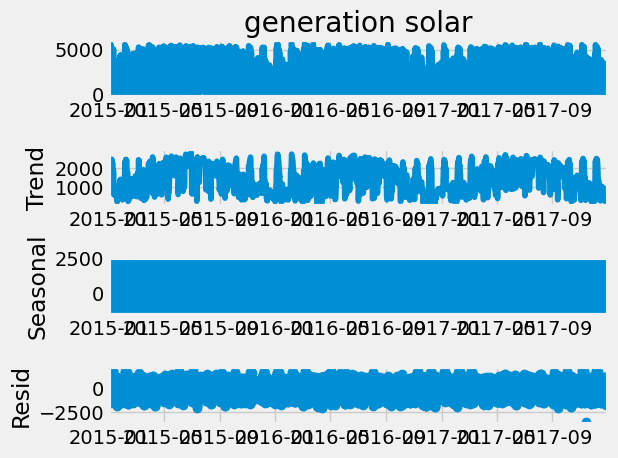

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series
decomposition = seasonal_decompose(y_solar_train, model='additive', period=24)

# Plot the decomposed components
decomposition.plot()
plt.show()

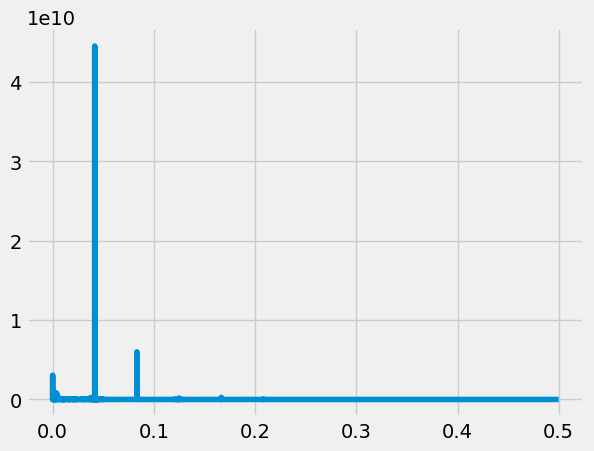

In [19]:
from scipy.signal import periodogram

frequencies, spectrum = periodogram(y_solar_train, detrend='linear')
plt.plot(frequencies, spectrum)
plt.show()

In [21]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

p = 1
d = 1
q = 0 

P = 0
D = 0
Q = 0


# Fit the SARIMA model
# Note: Replace the placeholders with the appropriate parameters based on your data
s = 24 # This is just an example; you should replace it with the seasonality of your dataset
model2 = SARIMAX(y_solar_train,
                order=(p, d, q),              # non-seasonal parameters
                seasonal_order=(P, D, Q, s),  # seasonal parameters
                enforce_stationarity=False,
                enforce_invertibility=False)

results2 = model2.fit()

# Print out the summary
print(results2.summary())


/Users/Daniyar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/Daniyar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.18808D+00    |proj g|=  1.34216D-05



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     12      1     0     0   1.339D-05   7.188D+00
  F =   7.1880841271046352     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                               SARIMAX Results                                
Dep. Variable:       generation solar   No. Observations:                26305
Model:               SARIMAX(1, 1, 0)   Log Likelihood             -189082.553
Date:                Sat, 20 Apr 2024   AIC                         378169.106
Time:                        19:57:06   BIC                         378185.461
Sample:                    1

In [22]:
forecast_results2 = model2.SARIMAXResults.get_forecast(steps=n_forecasts)
forecast2 = forecast_results.predicted_mean

mse2 = ((y_solar_test - forecast2) ** 2).mean()
print(f'The Mean Squared Error of our forecasts is {mse2}')


AttributeError: 'SARIMAX' object has no attribute 'SARIMAXResults'

In [ ]:
def find_best_sarima_model(y_train, y_test, p_values, d_values, q_values, P_values, D_values, Q_values, s):
    best_mse = float("inf")
    best_order = None
    best_seasonal_order = None
    
    for p in p_values:
        for d in d_values:
            for q in q_values:
                for P in P_values:
                    for D in D_values:
                        for Q in Q_values:
                            try:
                                # Fit SARIMA model
                                model = SARIMAX(y_train,
                                                order=(p, d, q),
                                                seasonal_order=(P, D, Q, s),
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                                results = model.fit(disp=0)
                                
                                # Forecast
                                forecasts = results.get_forecast(steps=len(y_test)).predicted_mean
                                
                                # Calculate MSE
                                mse = mean_squared_error(y_test, forecasts)
                                
                                if mse < best_mse:
                                    best_mse = mse
                                    best_order = (p, d, q)
                                    best_seasonal_order = (P, D, Q, s)
                                    
                                print(f'SARIMA{best_order}x{best_seasonal_order} - AIC:{results.aic} - MSE:{mse}')
                                
                            except Exception as e:
                                print(f'Error with model SARIMA({p},{d},{q})x({P},{D},{Q},{s}):', e)
    
    print(f'Best SARIMA model: SARIMA{best_order}x{best_seasonal_order} with MSE: {best_mse}')
    return best_order, best_seasonal_order, best_mse

# Example usage:
p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)
P_values = range(0, 3)
D_values = range(0, 2)
Q_values = range(0, 3)
s = 24  # replace with your dataset's seasonality

best_order, best_seasonal_order, best_mse = find_best_sarima_model(y_solar_train, y_solar_test, p_values, d_values, q_values, P_values, D_values, Q_values, s)

/Users/Daniyar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/Daniyar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 0)x(0, 0, 0, 24) - AIC:480154.4341118987 - MSE:4633650.566845531


/Users/Daniyar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/Daniyar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 0)x(0, 0, 0, 24) - AIC:458818.5402145684 - MSE:4634550.947558731


/Users/Daniyar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/Daniyar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 0)x(0, 0, 0, 24) - AIC:446906.37792197574 - MSE:4637225.04612115


/Users/Daniyar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/Daniyar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 0)x(0, 1, 0, 24) - AIC:429809.14914323273 - MSE:3243144.178559196


/Users/Daniyar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/Daniyar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 0)x(0, 1, 1, 24) - AIC:425217.884818944 - MSE:2562364.11375024


/Users/Daniyar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/Daniyar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 0)x(0, 1, 2, 24) - AIC:423688.16466452146 - MSE:1484187.430778532


/Users/Daniyar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/Daniyar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/Daniyar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(0, 0, 0)x(0, 1, 2, 24) - AIC:428816.0727412573 - MSE:4589528.483663205


/Users/Daniyar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/Daniyar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 0)x(0, 1, 2, 24) - AIC:425564.3289002219 - MSE:4333679.73753651


/Users/Daniyar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/Daniyar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 0)x(0, 1, 2, 24) - AIC:424365.1085411687 - MSE:1855512.8525613064


/Users/Daniyar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/Daniyar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 0)x(0, 1, 2, 24) - AIC:426690.5279361367 - MSE:2715775.5157629084


/Users/Daniyar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/Daniyar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 0)x(1, 1, 1, 24) - AIC:422547.9076424185 - MSE:1178788.4626955336


/Users/Daniyar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/Daniyar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 0)x(1, 1, 2, 24) - AIC:422346.6191671899 - MSE:1138204.901160092


/Users/Daniyar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/Daniyar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 0)x(1, 1, 2, 24) - AIC:426147.9372930926 - MSE:4515188.119517347


/Users/Daniyar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/Daniyar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 0)x(1, 1, 2, 24) - AIC:422807.4276703396 - MSE:1349715.4550643223


/Users/Daniyar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/Daniyar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 0)x(1, 1, 2, 24) - AIC:422654.22534724907 - MSE:1300692.1118629177


/Users/Daniyar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/Daniyar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 0)x(1, 1, 2, 24) - AIC:425406.50696660177 - MSE:2656640.1406732635


/Users/Daniyar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/Daniyar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

p_best = 0
d_best = 0
q_best = 0 

P_best = 1
D_best = 1
Q_best = 2


# Fit the SARIMA model
# Note: Replace the placeholders with the appropriate parameters based on your data
s = 365 # This is just an example; you should replace it with the seasonality of your dataset
model_best = SARIMAX(y_solar_train,
                order=(p_best, d_best, q_best),              # non-seasonal parameters
                seasonal_order=(P_best, D_best, Q_best, s),  # seasonal parameters
                enforce_stationarity=False,
                enforce_invertibility=False)

result_best = model_best.fit()

# Print out the summary
print(result_best.summary())


In [13]:
print(result_best.summary())

                                   SARIMAX Results                                   
Dep. Variable:              generation solar   No. Observations:                26305
Model:             SARIMAX(1, 1, [1, 2], 24)   Log Likelihood             -211169.310
Date:                       Sat, 20 Apr 2024   AIC                         422346.619
Time:                               21:18:58   BIC                         422379.318
Sample:                           12-31-2014   HQIC                        422357.178
                                - 12-31-2017                                         
Covariance Type:                         opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L24       0.6005      0.009     67.917      0.000       0.583       0.618
ma.S.L24      -1.1186      0.010   -111.008      0.000      -1.138      -1.

In [15]:
forecasts = result_best.get_forecast(steps=len(y_solar_test)).predicted_mean                                                            
mse = mean_squared_error(y_solar_test, forecasts)

In [16]:
print(mse)

1138204.901160092


In [17]:
conf_int = forecasts.conf_int()

AttributeError: 'Series' object has no attribute 'conf_int'

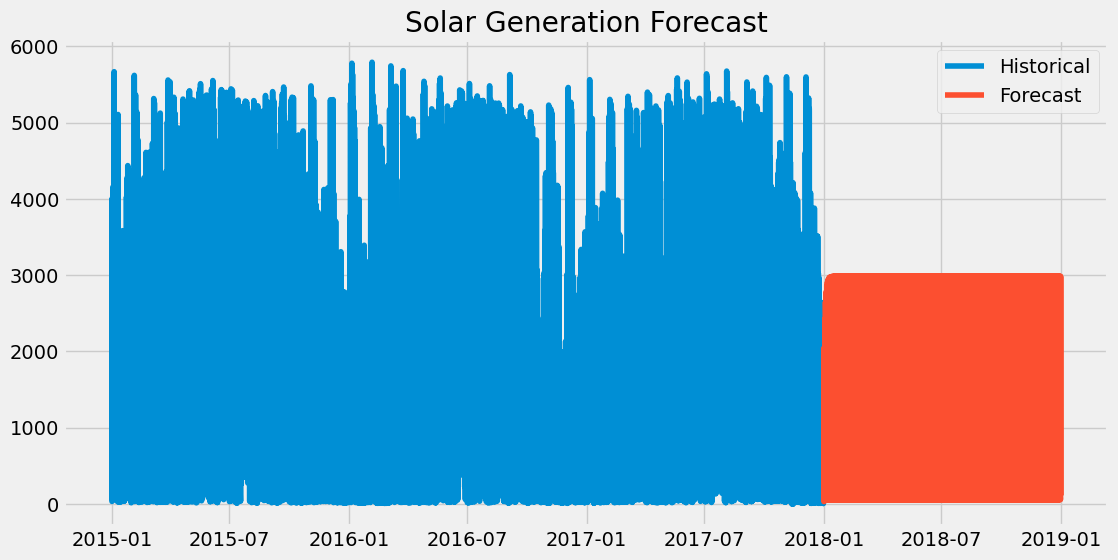

In [19]:
# Plot the forecast alongside the historical data
plt.figure(figsize=(12,6))
plt.plot(y_solar_train.index, y_solar_train, label='Historical')
plt.plot(y_solar_test.index, forecasts, label='Forecast')
#plt.fill_between(y_solar_test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Solar Generation Forecast')
plt.legend()
plt.show()

In [ ]:
mod = sm.tsa.arima.ARIMA(endog, order=(1, 0, 2), seasonal_order=(1, 1, 1, 365))
res = mod.fit(method='innovations_mle', low_memory=True, cov_type='none')